# Comparing models

In [1]:
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

### Parameters

In [2]:
BATCH_SIZE = 24
NUM_CLASSES = 64
NUM_FRAMES = 16
EPOCHS = 50
LR = 0.001

## Set up MLflow connection

In [3]:
import mlflow
import os

from mlflow.entities import Experiment
from mlflow.tracking import MlflowClient

MLFLOW_TRACKING_SERVER_URI = "http://localhost:5001"

os.environ["AWS_ACCESS_KEY_ID"] = "miniouser"
os.environ["AWS_SECRET_ACCESS_KEY"] = "miniopass"
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "http://localhost:9000/"

mlflow.set_tracking_uri(MLFLOW_TRACKING_SERVER_URI)
mlflow_client = MlflowClient(MLFLOW_TRACKING_SERVER_URI)

## Load model

In [4]:
def get_run_id(exp_name, run_name) -> str:
    experiment: Experiment = mlflow.set_experiment(experiment_name=exp_name)
    run = None

    matching_runs = mlflow_client.search_runs(
        experiment_ids=[experiment.experiment_id],
        filter_string=f"tags.mlflow.runName = '{run_name}'"
    )

    if len(matching_runs) > 0:
        run = matching_runs[0]
        return run.info.run_id
    else:
        raise Exception("Run inexistente!!!!!")

In [6]:
modelo_A_metadata = {
    "exp_name": "3D Molchanov 01",
    "run_name": "Execution 06",
    "run_id": None,
    "model_path": "3D Molchanov 01_Execution 06.pth",
}

modelo_A_metadata["run_id"] = get_run_id(exp_name=modelo_A_metadata["exp_name"], run_name=modelo_A_metadata["run_name"])

modelo_A_metadata["run_id"]

('dd0d232deb884dd89876306a84223ae1', '642d531a2c494c3493bc192f46a68c0a')

In [11]:
def load_state_dict(run_id: str, model_path: str):
    return mlflow_client.download_artifacts(
        run_id=run_id,
        path=model_path,
    )

In [12]:
import torch

from recognizer.models.molchanov_3d import Molchanov3DCNN

modelo_A = Molchanov3DCNN(num_classes=NUM_CLASSES, num_frames=NUM_FRAMES, batch_size=BATCH_SIZE)

modelo_A.load_state_dict(
    torch.load(load_state_dict(run_id=modelo_A_metadata["run_id"], model_path=modelo_A_metadata["model_path"]))
)

modelo_A.to("cuda")

INFO:botocore.credentials:Found credentials in environment variables.


Molchanov3DCNN(
  (conv_layer_1): Sequential(
    (0): Conv3d(3, 3, kernel_size=(5, 5, 5), stride=(1, 1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv3d(3, 5, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=48880, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=100, out_features=64, bias=True)
  )
)

In [13]:
dummy_input = torch.randn(24, 3, 16, 216, 384).cuda()

output = modelo_A(dummy_input)

print("Output shape:", output.shape)  # Should be [24, 64]

Output shape: torch.Size([24, 64])


In [14]:
from torchsummary import summary

summary(modelo_A, (3, 16, 216, 384), -1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1      [-1, 3, 12, 212, 380]           1,128
              ReLU-2      [-1, 3, 12, 212, 380]               0
         MaxPool3d-3       [-1, 3, 6, 106, 190]               0
            Conv3d-4       [-1, 5, 4, 104, 188]             410
              ReLU-5       [-1, 5, 4, 104, 188]               0
         MaxPool3d-6         [-1, 5, 2, 52, 94]               0
            Linear-7                  [-1, 100]       4,888,100
              ReLU-8                  [-1, 100]               0
           Dropout-9                  [-1, 100]               0
           Linear-10                   [-1, 64]           6,464
Total params: 4,896,102
Trainable params: 4,896,102
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 15.19
Forward/backward pass size (MB): 53.36
Params size (MB): 18.68
Esti

## Load testing set

In [15]:
import pandas as pd

from recognizer.utils.constants import ROOT_DIR, TARGET_TO_ENCODING
from recognizer.utils.utils import get_metadata_from_filename

DATASET_DIR_POSTA = ROOT_DIR / "data" / "all-20percent"

targets = []
subjects = []
repetitions = []
files = []

for file in os.listdir(DATASET_DIR_POSTA):

    target, subject, repetition = get_metadata_from_filename(file)

    targets.append(target)
    subjects.append(subject)
    repetitions.append(repetition)
    files.append(str((DATASET_DIR_POSTA / file).resolve()))


metadata = pd.DataFrame(
    data={
        "target": targets,
        "subject": subjects,
        "repetition": repetitions,
        "file": files,
    }
)

metadata["target_encoding"] = metadata["target"].map(TARGET_TO_ENCODING)

metadata.head()

,target,subject,repetition,file,target_encoding
0,001,001,001,C:\Users\facun\Desktop\DEV\ecd-trabajo-final\d...,0
1,001,001,002,C:\Users\facun\Desktop\DEV\ecd-trabajo-final\d...,0
2,001,001,003,C:\Users\facun\Desktop\DEV\ecd-trabajo-final\d...,0
3,001,001,004,C:\Users\facun\Desktop\DEV\ecd-trabajo-final\d...,0
4,001,001,005,C:\Users\facun\Desktop\DEV\ecd-trabajo-final\d...,0


### Pre-processing functions

In [16]:
def transform(x):
    """Permutes the element to match the format expected by PyTorch: (C<channels>, T<frames>, H<height>, W<width>)"""
    # Transpose video from (T<frames>, H<height>, W<width>, C<channels>) to (C<channels>, T<frames>, H<height>, W<width>)
    return x.permute(3, 0, 1, 2).float()


In [17]:
def load_testing_set_index(run_id: str):
    local_path = mlflow_client.download_artifacts(
        run_id=run_id,
        path="testing set index.txt",
    )

    with open(local_path, encoding="utf-8") as f:
        return f. read()

In [18]:
import re

test_idx_str_A = load_testing_set_index(
    run_id=modelo_A_metadata["run_id"],
)

test_idx_A = [int(x) for x in re.findall(r'\d+', test_idx_str_A)]

assert len(test_idx_A) == 640

In [19]:
testing_set_A = metadata.loc[test_idx_A]

testing_set_A.groupby("target")["subject"].count()

target
001    10
002    10
003    10
004    10
005    10
       ..
060    10
061    10
062    10
063    10
064    10
Name: subject, Length: 64, dtype: int64

In [20]:
from recognizer.dataset import SampledVideoDataset

In [21]:
testing_dataset_A = SampledVideoDataset(
    video_filenames=testing_set_A["file"].values,
    labels=testing_set_A["target_encoding"].values,
    num_frames=NUM_FRAMES,
    transform=transform,
)
test_loader_A = torch.utils.data.DataLoader(testing_dataset_A, batch_size=BATCH_SIZE, shuffle = False)

In [22]:
from torch import nn

loss_function = nn.CrossEntropyLoss()
device = "cuda"

### Make inferences again

In [23]:
import numpy as np

modelo_A.eval()

all_preds = []
all_targets = []
all_logits = []

running_testing_loss = 0.0

with torch.no_grad():
    for data in test_loader_A:
        inputs, labels = data[0].to(device), data[1].to(device)

        logits = modelo_A(inputs)

        _, preds = torch.max(logits, 1)

        all_preds.append(preds.cpu())
        all_targets.append(labels.cpu())
        all_logits.append(logits.cpu())

        loss = loss_function(logits, labels)
        running_testing_loss += loss.item()

average_testing_loss = running_testing_loss / len(test_loader_A)

all_preds = torch.cat(all_preds)
all_targets = torch.cat(all_targets)
all_logits = torch.cat(all_logits)

assert len(all_preds) == len(all_targets) == len(all_logits) == 640
assert len(np.unique(all_targets)) == NUM_CLASSES

## Calculate metrics

### Confusion Matrix

In [24]:
ENCODING_TO_TARGET: dict[int, str] = {v: k for k, v in TARGET_TO_ENCODING.items()}

In [25]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_targets, all_preds)

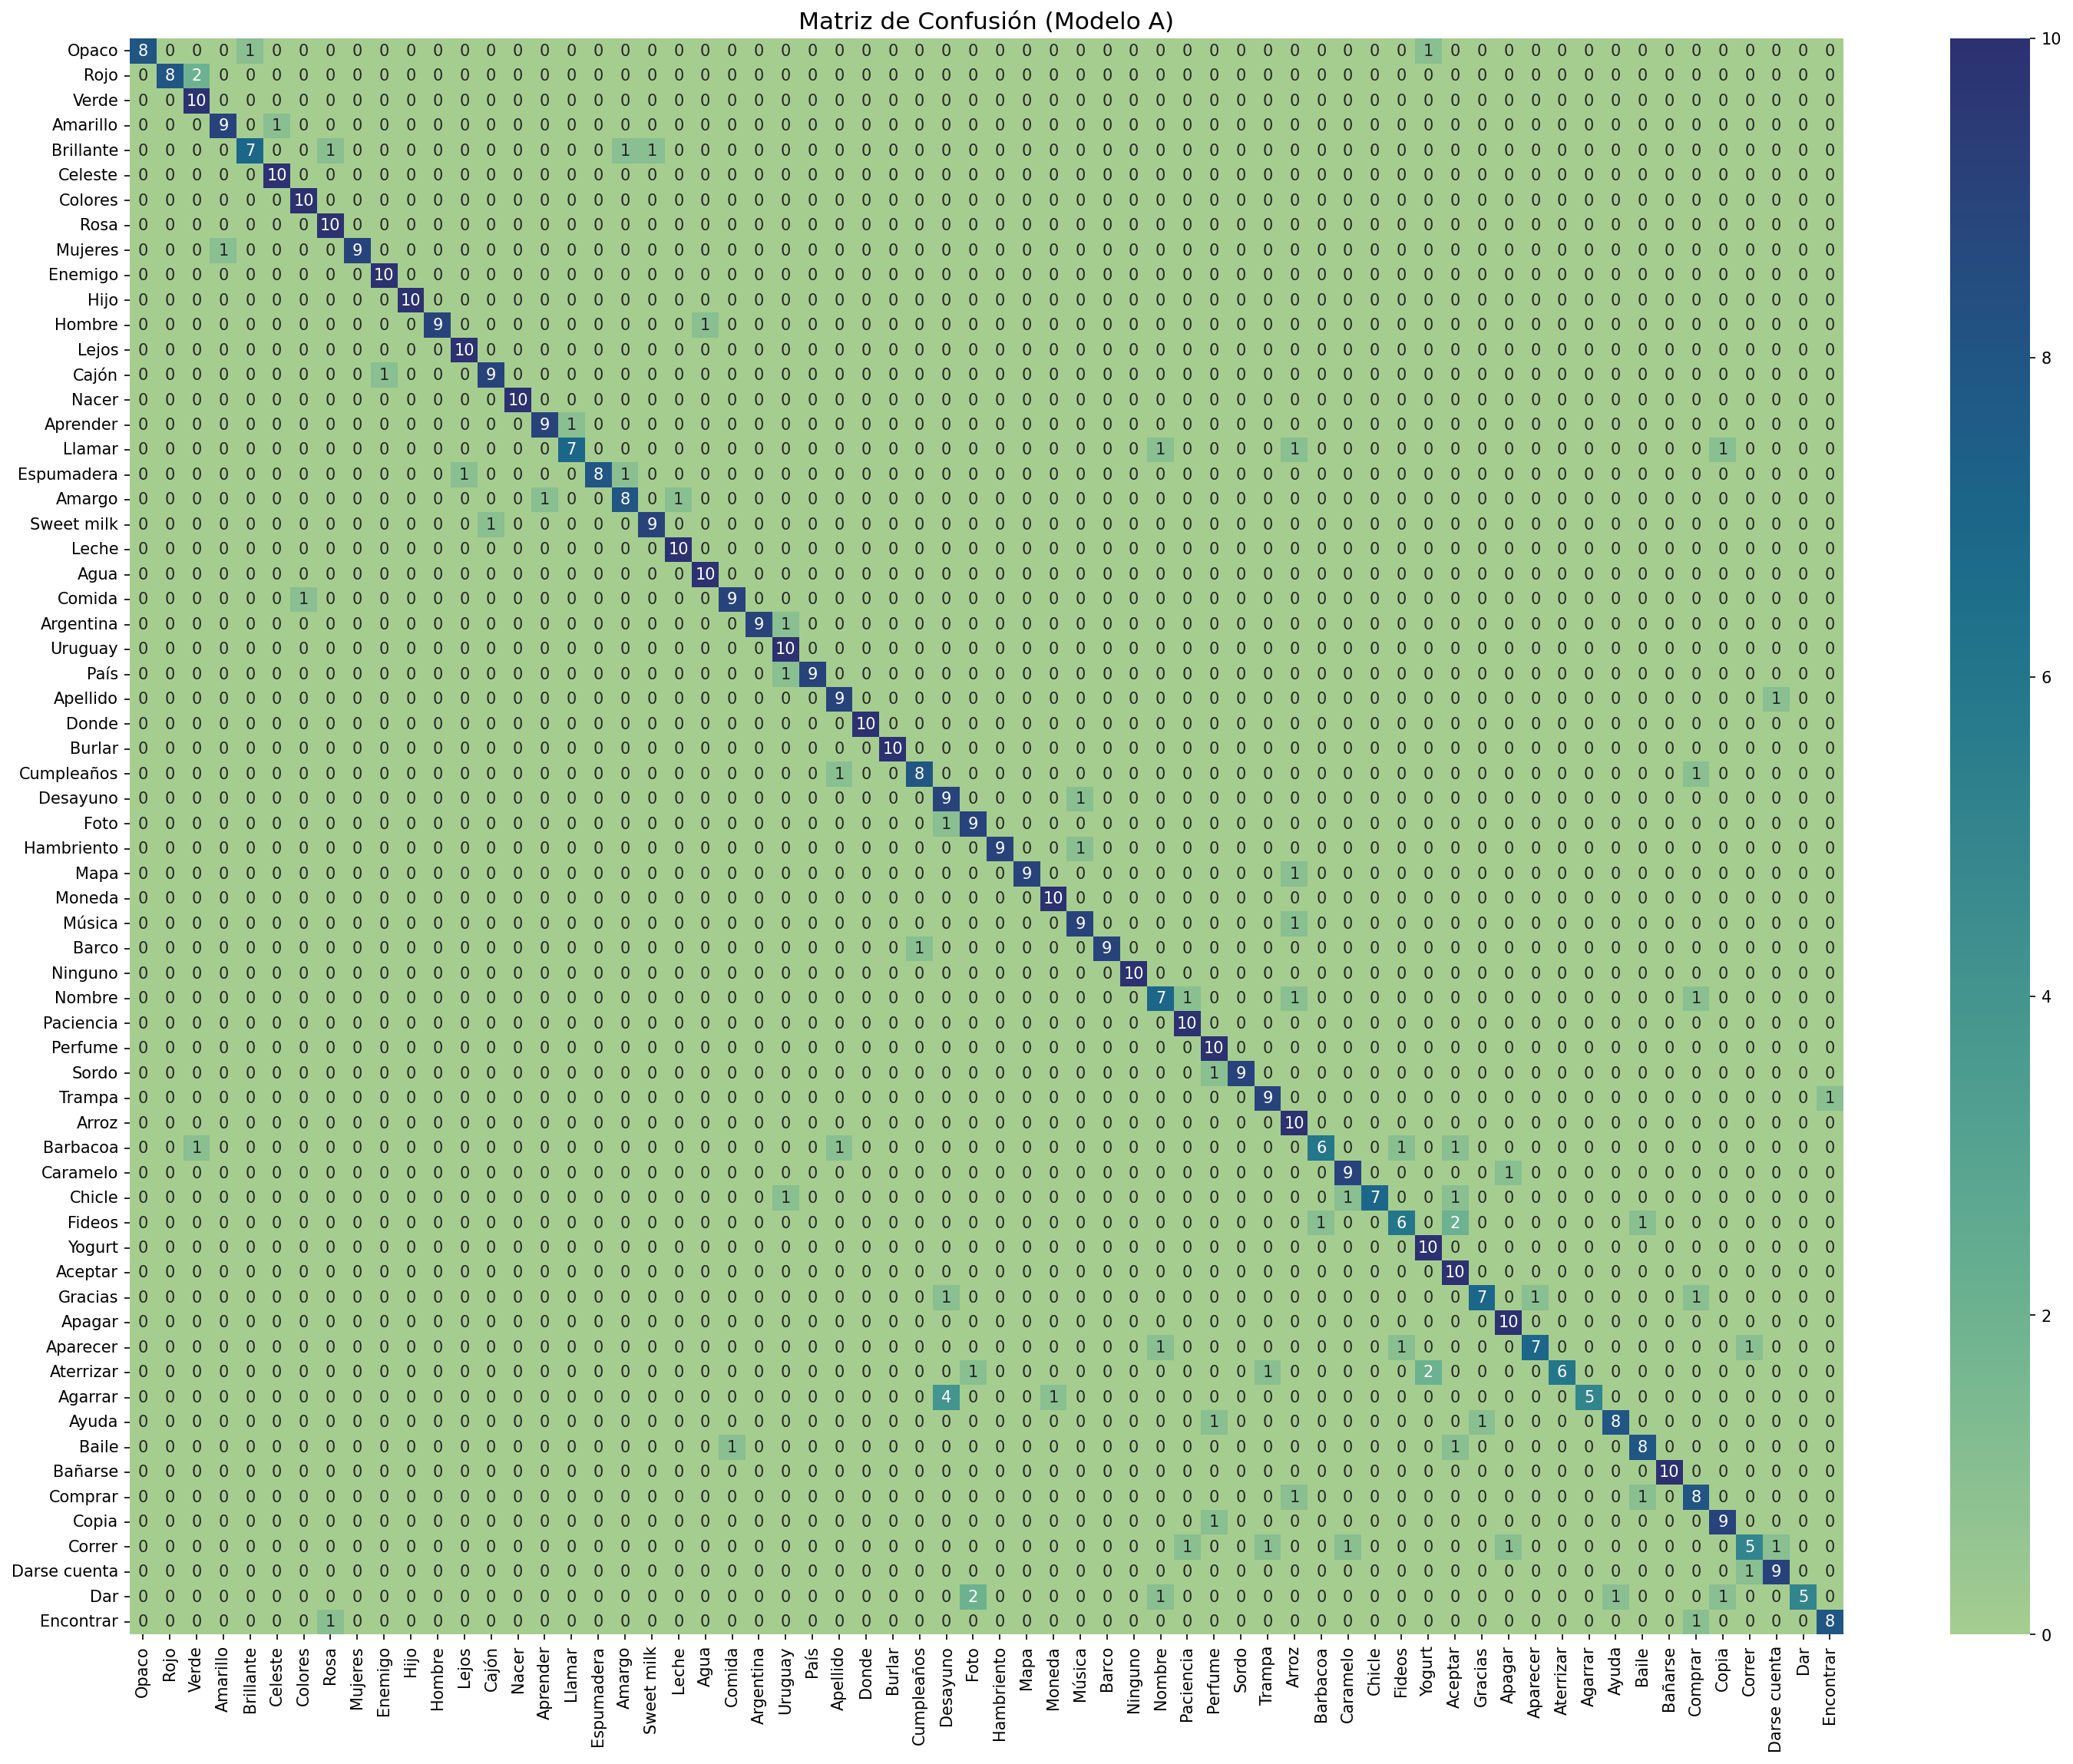

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

from recognizer.utils.constants import TARGET_TO_WORD_ES


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(24, 18), dpi=150, facecolor="white")

heatmap = sns.heatmap(data=cm, ax=ax, annot=True, cmap=sns.color_palette("crest", as_cmap=True))

x_ticks = [int(label.get_text()) for label in heatmap.get_xticklabels()]
y_ticks = [int(label.get_text()) for label in heatmap.get_yticklabels()]

x_new_labels = [TARGET_TO_WORD_ES[ENCODING_TO_TARGET[x]] for x in x_ticks]
y_new_labels = [TARGET_TO_WORD_ES[ENCODING_TO_TARGET[y]] for y in y_ticks]

heatmap.set_xticklabels(x_new_labels)
heatmap.set_yticklabels(y_new_labels)

plt.title("Matriz de Confusión (Modelo A)", fontdict={"fontsize": 15})
plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.show()


In [27]:
CLASSES = np.unique(all_preds)

In [28]:
cm.sum(axis=1)

array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10], dtype=int64)

In [29]:
np.sum(np.delete(cm, 2, axis=0)[:, 2])

3

### Precision/Recall/F1 per class

In [30]:
# We will store the results in a dictionary for easy access later
per_class_precisions = {}
per_class_recalls = {}
per_class_f1s = {}

# Calculate the accuracy for each one of our classes
for idx in CLASSES:
    # True positives are all the samples of our current GT class that were predicted as such
    true_positives = cm[idx, idx]

    false_positives = np.sum(np.delete(cm, idx, axis=0)[:, idx])
    false_negatives = np.sum(np.delete(cm, idx, axis=1)[idx, :])

    word = TARGET_TO_WORD_ES[ENCODING_TO_TARGET[idx]]

    precision = (true_positives) / (true_positives + false_positives)
    recall = (true_positives) / (true_positives + false_negatives)

    per_class_precisions[word] = precision
    per_class_recalls[word] = recall
    per_class_f1s[word] = 2 * (precision * recall) / (precision + recall)

In [31]:
precisions_df = pd.DataFrame.from_dict(per_class_precisions, orient="index", columns=["precision"])
precisions_df.index.name = "word"

recalls_df = pd.DataFrame.from_dict(per_class_recalls, orient="index", columns=["recall"])
recalls_df.index.name = "word"

f1s_df = pd.DataFrame.from_dict(per_class_f1s, orient="index", columns=["f1"])
f1s_df.index.name = "word"

In [32]:
metrics_df = (
    precisions_df
    .merge(recalls_df, how="inner", on="word")
    .merge(f1s_df, how="inner", on="word")
    .reset_index()
)

In [50]:
metrics_df.sort_values("recall", ascending=True).head()

,word,precision,recall,f1
60,Correr,0.714286,0.5,0.588235
62,Dar,1.000000,0.5,0.666667
54,Agarrar,1.000000,0.5,0.666667
53,Aterrizar,1.000000,0.6,0.750000
47,Fideos,0.750000,0.6,0.666667


In [51]:
metrics_df.loc[metrics_df["word"].isin(["Correr", "Dar", "Agarrar"]), :]

,word,precision,recall,f1
54,Agarrar,1.000000,0.5,0.666667
60,Correr,0.714286,0.5,0.588235
62,Dar,1.000000,0.5,0.666667


In [47]:
pd.DataFrame(
    [
        metrics_df.precision.describe(percentiles=[.1, .25, .5, .75, .9, .99]),
        metrics_df.recall.describe(percentiles=[.1, .25, .5, .75, .9, .99]),
        metrics_df.f1.describe(percentiles=[.1, .25, .5, .75, .9, .99]),
    ]
)

,count,mean,std,min,10%,25%,50%,75%,90%,99%,max
precision,64.0,0.882621,0.106210,0.600000,0.750000,0.818182,0.900000,1.000000,1.000000,1.0,1.0
recall,64.0,0.868750,0.140153,0.500000,0.700000,0.800000,0.900000,1.000000,1.000000,1.0,1.0
f1,64.0,0.866112,0.096305,0.588235,0.722182,0.800000,0.879227,0.947368,0.952381,1.0,1.0


### ROC AUC

In [34]:
all_preds_proba = nn.functional.softmax(all_logits, dim=1).numpy()

In [35]:
all_preds_proba[0]

array([4.93163526e-01, 1.56764090e-02, 2.56226602e-04, 6.15156409e-07,
       6.49211705e-02, 1.69172054e-05, 1.15748015e-04, 6.80132075e-07,
       3.03869256e-12, 4.72614774e-03, 7.25394944e-09, 1.94178810e-07,
       1.01393914e-06, 5.95427446e-06, 2.26803706e-03, 4.05636638e-01,
       2.87364781e-08, 7.33086793e-03, 7.23175690e-05, 4.61653364e-08,
       4.22803173e-03, 7.27679961e-13, 2.25581471e-06, 2.85595502e-06,
       7.46568458e-06, 1.34666881e-03, 3.16794768e-08, 5.40250422e-09,
       3.09809822e-09, 5.40145129e-06, 2.16717130e-11, 3.54349213e-05,
       3.62287630e-11, 8.45989149e-15, 5.53102703e-11, 3.54270524e-16,
       1.28650521e-10, 7.82962670e-12, 1.03303630e-10, 3.69682812e-10,
       5.27752952e-08, 5.74802705e-10, 4.54843177e-11, 6.92014588e-12,
       1.33189251e-05, 1.37344731e-08, 1.01753380e-06, 2.95599323e-10,
       1.54829003e-08, 3.24281657e-10, 2.60757554e-10, 1.46152587e-07,
       2.91788798e-08, 1.58324274e-11, 4.88492151e-06, 2.45538540e-05,
      

In [36]:
from sklearn.preprocessing import label_binarize

y_true = label_binarize(all_targets, classes=range(64))

y_true.shape

(640, 64)

In [37]:
from sklearn.metrics import roc_auc_score


roc_auc_micro = roc_auc_score(y_true, all_preds_proba, average="micro", multi_class="ovr")
roc_auc_macro = roc_auc_score(y_true, all_preds_proba, average="macro", multi_class="ovr")

roc_auc_micro, roc_auc_macro

(0.9966480654761906, 0.9971602182539684)

In [38]:
from sklearn.metrics import auc, roc_curve


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(64):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], all_preds_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

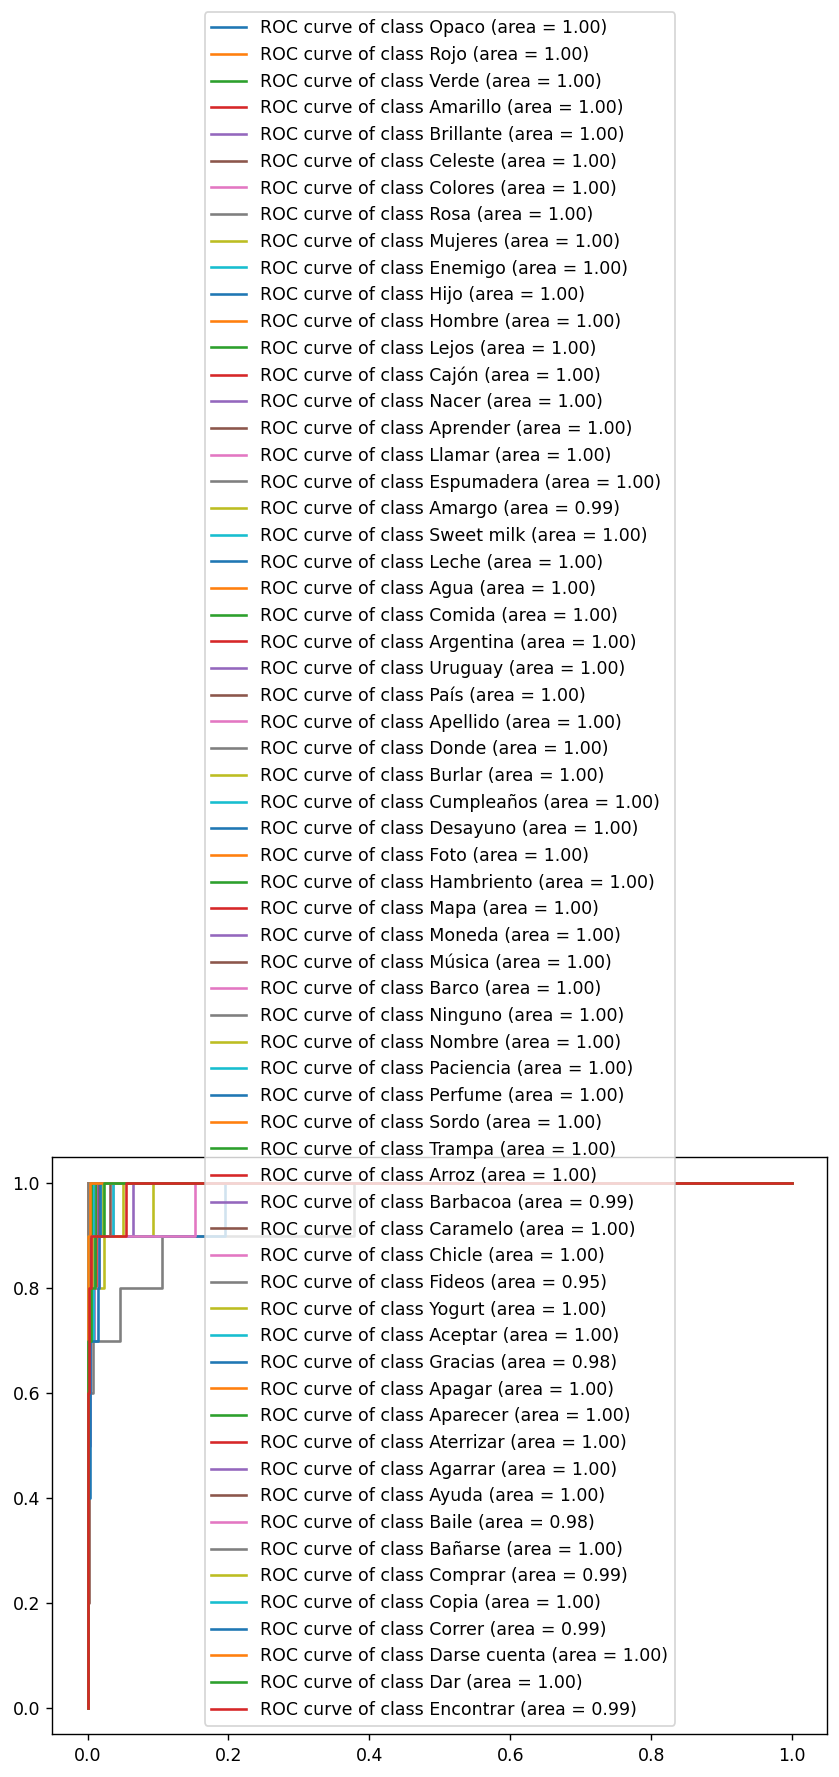

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=125, facecolor="white")

for i in range(64):
    ax.plot(fpr[i], tpr[i], label=f"ROC curve of class {TARGET_TO_WORD_ES[ENCODING_TO_TARGET[i]]} (area = {roc_auc[i]:0.2f})")

ax.legend()
plt.show()

## MLFlow metrics

#### Loss over time

In [40]:
training_losses = mlflow_client.get_metric_history(run_id=modelo_A_metadata["run_id"], key="training_loss")
testing_losses = mlflow_client.get_metric_history(run_id=modelo_A_metadata["run_id"], key="testing_loss")

In [41]:
training_losses = [{'step': metric.step, 'training_loss': metric.value} for metric in training_losses]
testing_losses = [{'step': metric.step, 'testing_loss': metric.value} for metric in testing_losses]

In [42]:
losses_df = (
    pd.DataFrame(training_losses)
    .merge(pd.DataFrame(testing_losses), on="step")
    .sort_values("step")
)

losses_df.head()

,step,training_loss,testing_loss
0,0,8.78,4.09
1,1,3.89,3.33
2,2,2.91,2.12
3,3,1.94,1.39
6,4,1.39,1.00


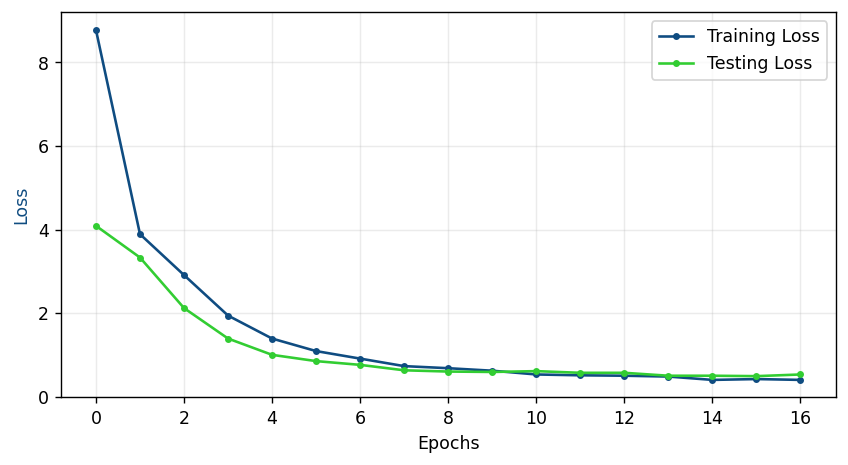

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=125, facecolor="white")

ax.plot(losses_df["step"], losses_df["training_loss"], label=f"Training Loss", color="#0F4C81", marker=".")
ax.plot(losses_df["step"], losses_df["testing_loss"], label=f"Testing Loss", color="#32CD32", marker=".")

ax.grid(alpha=0.25)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss", color="#0F4C81")
ax.legend()
plt.show()

#### Accuracy/Precision/Recall over time

In [44]:
import pandas as pd

accuracies_over_time = mlflow_client.get_metric_history(run_id=modelo_A_metadata["run_id"], key="accuracy")
precisions_over_time = mlflow_client.get_metric_history(run_id=modelo_A_metadata["run_id"], key="precision")
recalls_over_time = mlflow_client.get_metric_history(run_id=modelo_A_metadata["run_id"], key="recall")

accuracies_over_time = [{'step': metric.step, 'accuracy': metric.value} for metric in accuracies_over_time]
precisions_over_time = [{'step': metric.step, 'precision': metric.value} for metric in precisions_over_time]
recalls_over_time = [{'step': metric.step, 'recall': metric.value} for metric in recalls_over_time]

metrics_over_time_df = (
    pd.DataFrame(accuracies_over_time)
    .merge(pd.DataFrame(precisions_over_time), on="step")
    .merge(pd.DataFrame(recalls_over_time), on="step")
    .sort_values("step")
)

metrics_over_time_df.head()

,step,accuracy,precision,recall
0,0,0.031250,0.027865,0.031250
1,1,0.184375,0.195768,0.184375
2,2,0.496875,0.579971,0.496875
3,3,0.670312,0.706757,0.670312
10,4,0.742188,0.759916,0.742188


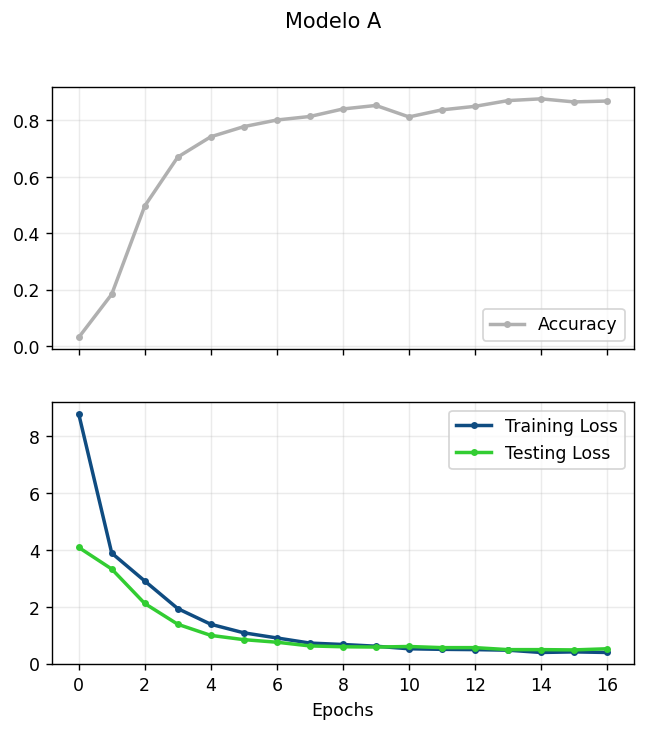

In [45]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(6, 6), dpi=125, facecolor="white", sharex=True)

line_kwargs = {"marker": ".", "linewidth": 2}

axs[0].plot(metrics_over_time_df["step"], metrics_over_time_df["accuracy"], label=f"Accuracy", color="#B0B0B0", **line_kwargs)
axs[0].legend(loc="lower right")
axs[0].grid(alpha=0.25)

axs[1].plot(losses_df["step"], losses_df["training_loss"], label=f"Training Loss", color="#0F4C81", **line_kwargs)
axs[1].plot(losses_df["step"], losses_df["testing_loss"], label=f"Testing Loss", color="#32CD32", **line_kwargs)

axs[1].set_xlabel("Epochs")
axs[1].legend()
axs[1].grid(alpha=0.25)

fig.suptitle("Modelo A")
plt.show()